In [1]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

In [2]:
# Import Datasets
test_data = pd.read_csv('2025_marathon_data.csv')
train_data = pd.read_csv('historical_marathon_dataset.csv')

event_vars = pd.read_csv('2025_event_vars.csv')
summary_vars = pd.read_csv('event_summary.csv')

In [3]:
# Standardise country names
country_mapping = {
    'USA': 'United States',
    'US': 'United States',
    'Australia': 'Australia', 
    'Aus': 'Australia',
    'Australaia': 'Australia',
    'kenya': 'Kenya',
    '   kenya    ': 'Kenya'
}

# Apply the mapping to both datasets BEFORE encoding
train_data['country'] = train_data['country'].replace(country_mapping)
test_data['country'] = test_data['country'].replace(country_mapping)

In [4]:
# Add event conditions to other datasets
# train_data
train_data = train_data.merge(summary_vars, on='year', how='left')

# test_data
for col in event_vars.columns:
    test_data[col] = event_vars.iloc[0][col]

In [5]:
# Drop irrelevant column
train_data = train_data.drop(columns=['newsletter_registration'])
test_data = test_data.drop(columns=['newsletter_registration'])

# Setup the feature columns
base_features = ['age', 'gender', 'height', 'weight', 'weekly_km', 'country', 'shoe_brand', 'marathons_xp', 'personal_best', 'injured_prev_mth', 
                  'injured_prev_qtr', 'injured_prev_hy']

event_features = [
    'temp_10am', 'humidity', 'rainfall', 'elevation_gain',
    'hydration_stations', 'stretching_station',
    'music_at_start', 'toilet_stations', 'crowding_density',
]

# Define the predictor columns
predictor_cols = (
    base_features +
    event_features
)

In [6]:
# Create binary target from availability of medical_km_bin
train_data['medical_attn'] = train_data['medical_km_bin'].notna().astype(int)

In [7]:
# Label encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_columns = train_data.select_dtypes(include='object').columns.tolist()
for col in categorical_columns:
    if col in test_data.columns:
        le = LabelEncoder()
        train_data[col] = le.fit_transform(train_data[col])
        result = []
        for val in test_data[col]:
            if val in le.classes_:
                result.append(le.transform([val])[0])
            else:
                result.append(-1)
        test_data[col] = result

In [8]:
# Prepare features and target
X = train_data[predictor_cols]
y = train_data['medical_attn']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = XGBClassifier(
    n_estimators=400, 
    max_depth=5, 
    learning_rate=0.05,
    scale_pos_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict on validation set
val_preds = model.predict(X_val)

# Evaluate
conf_matrix = confusion_matrix(y_val, val_preds)
class_report = classification_report(y_val, val_preds, output_dict=True)

In [9]:
# Train on full data and predict on test_data
X_test = test_data[predictor_cols]
final_preds = model.fit(X, y).predict(X_test)

# Output results
evaluation_results = {
    "Confusion Matrix": conf_matrix,
    "Classification Report": class_report,
    "Test Predictions (Sample)": final_preds[:10]
}

evaluation_results

{'Confusion Matrix': array([[6847, 3714],
        [ 927, 1112]]),
 'Classification Report': {'0': {'precision': 0.880756367378441,
   'recall': 0.6483287567465202,
   'f1-score': 0.7468775565857649,
   'support': 10561.0},
  '1': {'precision': 0.2304185661002901,
   'recall': 0.5453653751839137,
   'f1-score': 0.3239621267297888,
   'support': 2039.0},
  'accuracy': 0.6316666666666667,
  'macro avg': {'precision': 0.5555874667393655,
   'recall': 0.596847065965217,
   'f1-score': 0.5354198416577769,
   'support': 12600.0},
  'weighted avg': {'precision': 0.7755151946160481,
   'recall': 0.6316666666666667,
   'f1-score': 0.6784390993257383,
   'support': 12600.0}},
 'Test Predictions (Sample)': array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])}

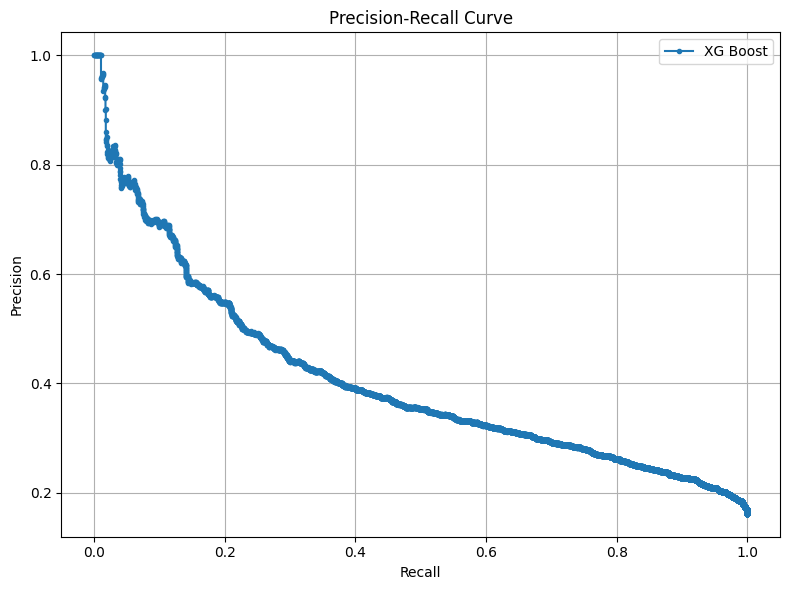

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the trained XGBoost model and validation set
# Get predicted probabilities for class 1
y_scores = model.predict_proba(X_val)[:, 1]

# Calculate precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XG Boost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import precision_recall_curve

# Get probabilities for class 1
probs = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)

# Example: find the threshold closest to 0.5 precision and 0.5 recall
target_precision = 0.5
target_recall = 0.5

best_idx = np.argmin(np.abs(precision - target_precision) + np.abs(recall - target_recall))
best_threshold = thresholds[best_idx]

# Apply threshold
final_preds = (probs > best_threshold).astype(int)

# Re-evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Threshold selected:", best_threshold)
print(confusion_matrix(y_val, final_preds))
print(classification_report(y_val, final_preds))

Threshold selected: 0.57392
[[8697 1864]
 [1020 1019]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     10561
           1       0.35      0.50      0.41      2039

    accuracy                           0.77     12600
   macro avg       0.62      0.66      0.64     12600
weighted avg       0.81      0.77      0.79     12600



In [12]:
from sklearn.metrics import accuracy_score

# Track best
best_accuracy = 0
best_threshold = 0

# Loop through thresholds from 0.1 to 0.9 (you can refine step size)
for t in np.arange(0.1, 0.91, 0.0001):
    preds = (probs > t).astype(int)
    acc = accuracy_score(y_val, preds)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = t
acc_threshold = best_threshold
print(f"✅ Best Accuracy: {best_accuracy:.4f} at Threshold: {best_threshold:.4f}")

✅ Best Accuracy: 0.8483 at Threshold: 0.7455


In [13]:
from sklearn.metrics import f1_score

best_f1 = 0
best_threshold = 0

for t in np.arange(0.05, 0.91, 0.005):  # Try from 5% to 90% in finer steps
    preds = (probs > t).astype(int)
    f1 = f1_score(y_val, preds, pos_label=1)  # Focus on class 1
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
f1_threshold = best_threshold
print(f"🎯 Best F1-Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

🎯 Best F1-Score: 0.4208 at Threshold: 0.5500


In [14]:
# Find average threshold -> Weighed at 60% to f1 score because identifying injuries is more important than false positives
threshold_avg = (acc_threshold * 0.4 + f1_threshold * 0.6)
# Use model on test data
test_copy = test_data.copy()
X_test = test_copy[predictor_cols].copy()
X_test = X_test.fillna(0)

test_probs = model.predict_proba(X_test)[:, 1]
test_preds = (test_probs > threshold_avg).astype(int)
np.unique(test_preds, return_counts=True)

test_copy['medical_attn_pred'] = test_preds

In [15]:
# Download to new CSV with results
test_copy.to_csv('Medical_attn_preds.csv', index=False)
print("Download to medical_attn_pred.csv")

Download to medical_attn_pred.csv


In [16]:
# Previous years
# 371, 500, 497, 465
# 2024.5 = 183 * 2
# 2024 = 261 * 2

SyntaxError: cannot assign to literal (1185854995.py, line 3)

OTHER STATISTICS

In [ ]:
# Other Statistics
import matplotlib.pyplot as plt
importances = model.feature_importances_

# Create a DataFrame for easier viewing
feature_importance_df = pd.DataFrame({
    'feature': predictor_cols,  # using your predictor_cols list
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Visualize the top features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)  # adjust number as needed
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features in XGBoost')
plt.gca().invert_yaxis()  # highest importance at top
plt.tight_layout()
plt.show()